Copyright (C) 2021  Alvaro Dias Simões, Annie Elisabeth Beltrão de Andrade and Iaquine Santos da Silva

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

<h1>Library Installation</h1>

In [1]:
pip install Biopython 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install modlamp 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy==1.19.3

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


<h1>Importing the Libraries </h1>

In [6]:
import numpy as np
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Tools that will be used in the training and analysis of the results
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix #CONSIDERAR DELETAR ISTO
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score #CONSIDERAR DELETAR ISTO
from sklearn.metrics import accuracy_score #CONSIDERAR DELETAR ISTO
from sklearn.metrics import multilabel_confusion_matrix #CONSIDERAR DELETAR ISTO
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import roc_curve, auc #CONSIDERAR DELETAR ISTO
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_regression

<h1>Preprocessing</h1>
<h2>Loading Databases with Pandas</h2>

In [8]:
campr3= pd.read_csv('All_Databases_Sequences_Campr3.csv') # Downloading databases; elements that cannot be used (function not known for exemple) were already excluded (were they?).
campr3.head()

,Camp_ID:,UniProt_id,PDB_id,Title:,Source_Organism:,Taxonomy:,Sequence,Length:,Pubmed_id:,Activity:,Validation:
0,CAMPSQ7,P84868,NaN,Sesquin,Vigna unguiculata subsp. sesquipedalis,Viridiplantae,KTCENLADTY,10,15949629,"Antibacterial, Antifungal, Antiviral",Experimentally Validated
1,CAMPSQ17,P84869,NaN,Antifungal lectin PVAP,Phaseolus vulgaris,Viridiplantae,SNDIYFNFQR,10,16026901,Antifungal,Experimentally Validated
2,CAMPSQ497,P84071,NaN,Ascalin,Allium cepa var. aggregatum,Viridiplantae,YQCGQGG,7,12126728,"Antifungal,Antiviral",Experimentally Validated
3,CAMPSQ498,P84073,NaN,Ribosome-inactivating protein luffacylin,Luffa aegyptiaca,Viridiplantae,PRGSPRTEYEAARR,14,12126727,Antifungal,Experimentally Validated
4,CAMPSQ519,P84200,NaN,Gymnin,Gymnocladus chinensis,Viridiplantae,KTCENLADDY,10,14499273,"Antifungal,Antiviral",Experimentally Validated


In [9]:
apd= pd.read_csv('All_Databases_Sequences_APD.csv')
apd.head()

,Name/Class:,Source:,Sequence,Length:,Net charge:,Hydrophobic residue%:,Boman Index:,Activity:,Reference:
0,"Hs-AFP1 (HsAFP1, H. sanguinea Antifungalprotei...",Heuchera sanguinea,DGVKLCDVPSGTWSGHCGSSSKCSQQCKDREHFAYGGACHYQFPSV...,5400%,6,33%,1.95 kcal/mol,Antifungal,FEBS Lett. 1995 Jul 17;368(2):257-62. PubMed.
1,"Ct-AMP1 (CtAMP1, C. ternatea-antimicrobial pep...",Clitoria ternatea,NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC,4900%,5,36%,2.43 kcal/mol,Antibactericidal_Antifungal,FEBS Lett. 1995 Jul 17;368(2):257-62. PubMed.
2,"NmDef02 (defensins; 3S=S, UCSS1a; plants)",Nicotiana megalosiphon,RECKAQGRHGTCFRDANCVQVCEKQAGWSHGDCRAQFKCKCIFEC,4500%,5,42%,2.62 kcal/mol,Antifungal,Plant Biotechnol J. 2010 Aug;8(6):678-90. PubMed.
3,MBP-1 (Maize Basic Peptide 1; hairpin-like pep...,"Maize, Zea mays L.",RSGRGECRRQCLRRHEGQPWETQECMRRCRRRG,3300%,7,21%,6.06 kcal/mol,Antibactericidal_Antifungal,J. Biol. Chem. 1992; 267:18814-18820
4,"Ac-AMP2 (A. caudatus antimicrobial peptide 2, ...","seeds, Amaranthus caudatus",VGECVRGRCPSGMCCSQFGYCGKGPKYCGR,3000%,4,33%,1.58 kcal/mol,Antibactericidal_Antifungal,Biochemistry. 1992 May 5;31(17):4308-14


<h2>Definition of the Functions for Determining the Attributes<h2\>

In [10]:
# Function for creating a dataframe with Biopython resources
def biopython_df(list):
  AA_Freq = []
  MW = []
  IP =[]
  GVY = []
  lenght =[]
  for j in list:
      a = ProteinAnalysis(str(j))
      AA_Freq.append(a.get_amino_acids_percent())
      MW.append(a.molecular_weight())
      IP.append(a.isoelectric_point())
      GVY.append(a.gravy())
      lenght.append(len(j))

  df= pd.DataFrame.from_dict(AA_Freq)
  df['MW_BP'] = MW
  df['lenght_BP'] = lenght
  df['IP_BP'] = IP
  df['GVY'] = GVY

  return df

In [11]:
# Function for creating a dataframe with Modlamp resources
def modlamp_df(list):
  brr=[]
  names =[]
  output=[]
  for i in list:
    arc = GlobalDescriptor(i)
    arc.calculate_all(amide=True)
    names = arc.featurenames
    brr.append(arc.descriptor)
    output = [elem for twod in brr for elem in twod]
    df = pd.DataFrame(output, columns=names)
 
  return df

<h2>Data Manipulation<h2\>

In [12]:
apdlst=apd['Sequence'].to_list() #Biopython and Modlamp calculate their parameters from the peptide sequence, so that is the only column needed

In [13]:
#Generating dataframe with Biopython
apd_BP= biopython_df(apdlst)
apd_BP.head()

,A,C,D,E,F,G,H,I,K,L,...,R,S,T,V,W,Y,MW_BP,lenght_BP,IP_BP,GVY
0,0.037037,0.148148,0.055556,0.018519,0.055556,0.111111,0.055556,0.000000,0.092593,0.018519,...,0.037037,0.129630,0.018519,0.055556,0.018519,0.037037,5948.6696,54,8.490825,-0.612963
1,0.061224,0.163265,0.040816,0.040816,0.040816,0.102041,0.061224,0.000000,0.061224,0.040816,...,0.061224,0.040816,0.081633,0.000000,0.061224,0.020408,5614.2215,49,8.210194,-0.848980
2,0.088889,0.177778,0.044444,0.066667,0.066667,0.088889,0.044444,0.022222,0.088889,0.000000,...,0.088889,0.022222,0.022222,0.044444,0.022222,0.000000,5138.8542,45,8.513260,-0.677778
3,0.000000,0.121212,0.000000,0.121212,0.000000,0.121212,0.030303,0.000000,0.000000,0.030303,...,0.333333,0.030303,0.030303,0.000000,0.030303,0.000000,4130.6776,33,11.351545,-2.033333
4,0.000000,0.200000,0.000000,0.033333,0.033333,0.233333,0.000000,0.000000,0.066667,0.000000,...,0.100000,0.066667,0.000000,0.066667,0.000000,0.066667,3189.7399,30,8.919539,-0.346667


In [14]:
#Generating dataframe with Modlamp
apd_ML= modlamp_df(apdlst)
apd_ML.head()

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio
0,54.0,5947.71,2.878,0.000484,8.126221,57.074074,0.111111,27.037037,1.954444,0.314815
1,49.0,5613.26,1.881,0.000335,7.916870,16.722449,0.122449,22.040816,2.433673,0.306122
2,45.0,5137.89,2.842,0.000553,8.129395,26.080000,0.088889,30.444444,2.629556,0.400000
3,33.0,4129.70,7.418,0.001796,11.675171,166.169697,0.030303,11.818182,6.064545,0.181818
4,30.0,3188.77,4.061,0.001274,8.708252,21.883333,0.100000,19.333333,1.587333,0.333333


In [15]:
# Grouping of data obtained from Biopython and modlamp; redundant columns are removed
data_apd= pd.concat([apd_BP,apd_ML], axis=1, sort=False)
data_apd = data_apd.drop(columns=['Length', 'MW', 'pI'])
apd_label = apd['Activity:'].to_list()
data_apd['Label'] = apd_label
data_apd.head()

,A,C,D,E,F,G,H,I,K,L,...,IP_BP,GVY,Charge,ChargeDensity,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio,Label
0,0.037037,0.148148,0.055556,0.018519,0.055556,0.111111,0.055556,0.000000,0.092593,0.018519,...,8.490825,-0.612963,2.878,0.000484,57.074074,0.111111,27.037037,1.954444,0.314815,Antifungal
1,0.061224,0.163265,0.040816,0.040816,0.040816,0.102041,0.061224,0.000000,0.061224,0.040816,...,8.210194,-0.848980,1.881,0.000335,16.722449,0.122449,22.040816,2.433673,0.306122,Antibactericidal_Antifungal
2,0.088889,0.177778,0.044444,0.066667,0.066667,0.088889,0.044444,0.022222,0.088889,0.000000,...,8.513260,-0.677778,2.842,0.000553,26.080000,0.088889,30.444444,2.629556,0.400000,Antifungal
3,0.000000,0.121212,0.000000,0.121212,0.000000,0.121212,0.030303,0.000000,0.000000,0.030303,...,11.351545,-2.033333,7.418,0.001796,166.169697,0.030303,11.818182,6.064545,0.181818,Antibactericidal_Antifungal
4,0.000000,0.200000,0.000000,0.033333,0.033333,0.233333,0.000000,0.000000,0.066667,0.000000,...,8.919539,-0.346667,4.061,0.001274,21.883333,0.100000,19.333333,1.587333,0.333333,Antibactericidal_Antifungal


In [16]:
# Excluding labels which cannot be used on the training testing (either not experimentally defined or the number availabe is too little)
test = campr3[['Sequence','Activity:']]
test = test[test['Activity:'] != 'Antimicrobial']
test = test[test['Activity:'] != 'Antibacterial, Anticancer']
test = test[test['Activity:'] != 'Antibacterial,Antifungal,Antiviral']
test = test[test['Activity:'] != 'Antibacterial, Antifungal, Antiviral']
test = test[test['Activity:'] != 'Anticancer, Antibacterial']
test = test[test['Activity:'] != 'Antifungal,Antiviral']

In [17]:
# Some of the sequences include dummy amino acid "X" and will be dropped
for index, row in test.Sequence.iteritems():
  if ("X" in row):
      test=test.drop(index)

In [18]:
# the amino acid marked as "B" is also not well defined, so sequences containing it are also dropped
for index, row in test.Sequence.iteritems():
  if ("B" in row):
      test=test.drop(index)

In [19]:
# Now we can apply the same process done with apd to the camp3 database
campr3lst=test['Sequence'].to_list()

In [20]:
campr3_BP= biopython_df(campr3lst)
campr3_ML= modlamp_df(campr3lst)
data_campr3= pd.concat([campr3_BP,campr3_ML], axis=1, sort=False)
data_campr3 = data_campr3.drop(columns=['Length', 'MW', 'pI'])

<h2>Conversion of Categoric Labels to Numeric Ones<h2\>

In [21]:
data_campr3['Label']= test['Activity:'].to_list()

In [22]:
# Converting the labels to numeric value for easier use
arrumar_labels_campr3= {'Label':{'Antifungal':0,'Antibacterial':1,'Antiviral':2,
                          'Antibacterial,Antifungal':3, 'Antibacterial, Antifungal':3,
                          'Antibacterial,antifungal':3}}
data_campr3.replace(arrumar_labels_campr3, inplace=True)

In [23]:
data_campr3.Label.value_counts(normalize=True)*100

0    54.181818
3    25.090909
1    12.727273
2     8.000000
Name: Label, dtype: float64

In [24]:
arrumar_labels_apd= {'Label':{'Antifungal':0,'Antibactericidal':1,'Antiviral':2, 'Antiviral ':2,
                          'Antibactericidal_Antifungal':3, 'Antibactericidal,':1}}
data_apd.replace(arrumar_labels_apd, inplace=True)

In [25]:
# Combining data from both sets
df = data_apd.append(data_campr3)
df.Label.value_counts(normalize=True)*100

0    46.028513
3    29.124236
1    16.293279
2     8.553971
Name: Label, dtype: float64

<h2>Attributes Selection<h2\>

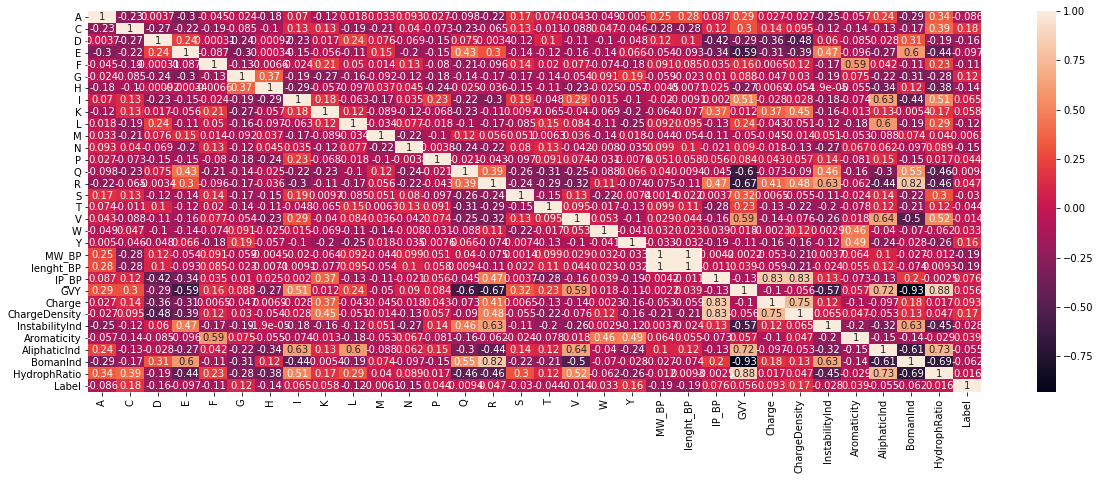

In [26]:
# A heatmap allows visualization of the correlation of the attributes, so that those highly correlacted can be selectedand one excluded
plt.figure(figsize=(20,7))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [27]:
# Automatically detecting and dropping the highly correlated
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

In [28]:
# Class count
count_class_0, count_class_1, count_class_2,count_class_3 = df.Label.value_counts()
# Divide by class
df_class_0 = df[df['Label']== 0]
df_class_1 = df[df['Label'] == 1]
df_class_2 = df[df['Label'] == 2]
df_class_3 = df[df['Label'] == 3]

In [29]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state=42)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)
df_class_2_over = df_class_2.sample(count_class_0, replace=True, random_state=42)
df_test_over2 = pd.concat([df_class_0, df_class_2_over], axis=0)
df_class_3_over = df_class_3.sample(count_class_0, replace=True, random_state=42)
df_test_over3 = pd.concat([df_class_0, df_class_1_over,df_class_2_over,df_class_3_over], axis=0)

In [30]:
# Separating groups for training and testing of the model
X= df_test_over3.drop(columns=['Label'])
y= df_test_over3['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
# Part of the models work best if we give the variables similar scales
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train_scale = scaler.transform(X_train)  
X_test_scale = scaler.transform(X_test)  

<h1>Generating the Learning Models (Neural Network, Decision Tree, SVM, XGBoost)<h1\>

In [32]:
# Using neural network; the parameters of all the models were tested previously and the results wil be grouped at the end
clfnn = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(100, 20), random_state=1, max_iter=300)
clfnn.fit(X_train_scale, y_train)
ynn = clfnn.predict(X_test_scale)

In [33]:
# Now, decision tree classifier
clftree = DecisionTreeClassifier(random_state=0)
clftree.fit(X_train_scale, y_train)
ytree = clftree.predict(X_test_scale)

In [34]:
# Support vector machine; in previous tests, radial kernel and C value of 100 delivered better results.
clfsvm = SVC(random_state = 1, kernel = 'rbf', C = 100, decision_function_shape='ovo')
clfsvm.fit(X_train_scale, y_train)
ysvm = clfsvm.predict(X_test_scale)

In [35]:
# Finally, we use the XGBoost implementation; 
clfxgb = XGBClassifier(max_depth = 3, n_estimators = 1500, objective = 'multi:softmax', grow_policy = 'lossguide', 
                      booster = 'gbtree', eval_metric = 'mlogloss', use_label_encoder = False)
clfxgb.fit(X_train_scale, y_train)
yxgb = clfxgb.predict(X_test_scale)

In [36]:
# Each implementation has its own values for precision recall and f1-score for each of the labels
pnn,rnn,fnn,snn = precision_recall_fscore_support(ynn, y_test)
ptree,rtree,ftree,stree = precision_recall_fscore_support(ytree, y_test)
psvm,rsvm,fsvm,ssvm = precision_recall_fscore_support(ysvm, y_test)
pxgb,rxgb,fxgb,sxgb = precision_recall_fscore_support(yxgb, y_test)

In [37]:
# Grouping the results on a dataframe for easier visualization
result = {'Model':['Neural Network', 'Decision Tree', 'Support Vector Machine', 'XGBoost'],
        'Precision (Antifungal)':[pnn[0], ptree[0], psvm[0], pxgb[0]],
        'Precision (Antibacterial)':[pnn[1], ptree[1], psvm[1], pxgb[1]],
        'Precision (Antiviral)':[pnn[2], ptree[2], psvm[2], pxgb[2]],
        'Precision (Antifungal and Antibacterial)':[pnn[3], ptree[3], psvm[3], pxgb[3]],
        'Recall (Antifungal)':[rnn[0], rtree[0], rsvm[0], rxgb[0]],
        'Recall (Antibacterial)':[rnn[1], rtree[1], rsvm[1], rxgb[1]],
        'Recall (Antiviral)':[rnn[2], rtree[2], rsvm[2], rxgb[2]],
        'Recall (Antifungal and Antibacterial)':[rnn[3], rtree[3], rsvm[3], rxgb[3]],
        'F1-Score (Antifungal)':[fnn[0], ftree[0], fsvm[0], fxgb[0]],
        'F1-Score (Antibacterial)':[rnn[1], rtree[1], rsvm[1], fxgb[1]],
        'F1-Score (Antiviral)':[fnn[2], ftree[2], fsvm[2], fxgb[2]],
        'F1-Score (Antifungal and Antibacterial)':[fnn[3], ftree[3], fsvm[3], fxgb[3]]}
dataresult = pd.DataFrame(result)
acc = []
test = [ynn, ytree, ysvm, yxgb]
for i in test:
    acc.append(accuracy_score(i, y_test))
    
dataresult['Accuracy'] = acc
dataresult

,Model,Precision (Antifungal),Precision (Antibacterial),Precision (Antiviral),Precision (Antifungal and Antibacterial),Recall (Antifungal),Recall (Antibacterial),Recall (Antiviral),Recall (Antifungal and Antibacterial),F1-Score (Antifungal),F1-Score (Antibacterial),F1-Score (Antiviral),F1-Score (Antifungal and Antibacterial),Accuracy
0,Neural Network,0.830986,0.9375,1.0,0.847222,0.907692,0.882353,1.000000,0.835616,0.867647,0.882353,1.000000,0.841379,0.906355
1,Decision Tree,0.690141,0.9250,1.0,0.847222,0.859649,0.870588,0.962025,0.782051,0.765625,0.870588,0.980645,0.813333,0.869565
2,Support Vector Machine,0.845070,0.9500,1.0,0.875000,0.923077,0.904762,1.000000,0.851351,0.882353,0.904762,1.000000,0.863014,0.919732
3,XGBoost,0.802817,0.9500,1.0,0.861111,0.904762,0.883721,1.000000,0.837838,0.850746,0.915663,1.000000,0.849315,0.906355


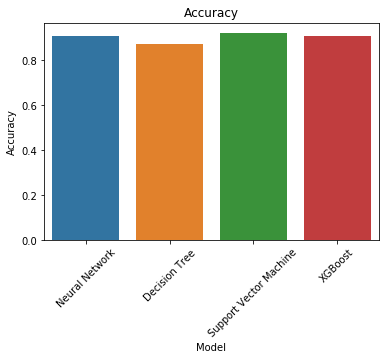

In [39]:
# Finally, plotting the results
sns.barplot(y='Accuracy', x='Model', data=dataresult)
plt.title('Accuracy')
plt.xticks(rotation=45);

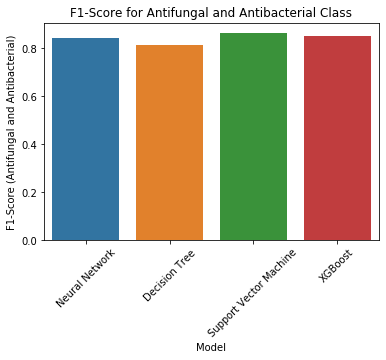

In [40]:
sns.barplot(y='F1-Score (Antifungal and Antibacterial)', x='Model', data=dataresult)
plt.title('F1-Score for Antifungal and Antibacterial Class')
plt.xticks(rotation=45);

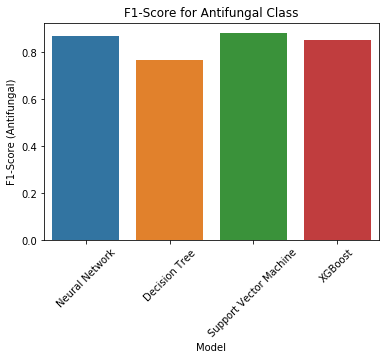

In [41]:
sns.barplot(y='F1-Score (Antifungal)', x='Model', data=dataresult)
plt.title('F1-Score for Antifungal Class')
plt.xticks(rotation=45);

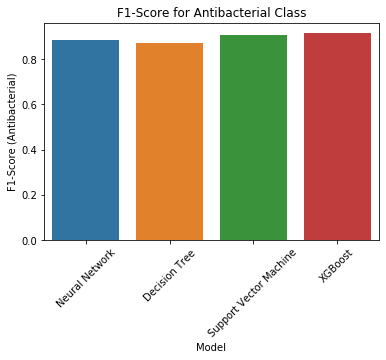

In [42]:
sns.barplot(y='F1-Score (Antibacterial)', x='Model', data=dataresult)
plt.title('F1-Score for Antibacterial Class')
plt.xticks(rotation=45);

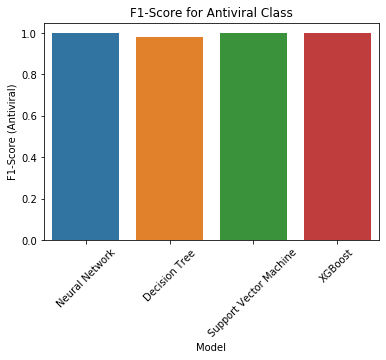

In [43]:
sns.barplot(y='F1-Score (Antiviral)', x='Model', data=dataresult)
plt.title('F1-Score for Antiviral Class')
plt.xticks(rotation=45);